In [1]:
import magpylib as magpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import einops as eo

import sklearn
import scipy as sp
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator, RegularGridInterpolator
 
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import itertools

from pathos.multiprocessing import ProcessingPool as Pool
import functools
import os
from numba import jit, njit

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.__version__

'1.23.5'

X[path][axis] B[magnet][pixel][path][axis]

We want to either interpolate B with X and then do a root optimization, or interpolate X with B. 

In [2]:
class DiscreteSensor(magpy.Sensor):
    def __init__(self, sensitivity=None, noise=None, position=(0,0,0), pixel=(0,0,0), orientation=None, style=None, **kwargs):
        self.sensitivity=sensitivity
        self.noise=noise
        super().__init__(position=position, pixel=pixel, orientation=orientation, style=style)
    def getB(self, *observers, squeeze=True, pixel_agg=None, output='ndarray'):
        B = super().getB(*observers, squeeze=squeeze, pixel_agg=pixel_agg, output=output)
        if self.noise!=None:
            rng = np.random.default_rng()
            B = B+rng.normal(scale=self.noise, size=B.shape)
        if self.sensitivity!=None:
            B = np.round(B/self.sensitivity)*self.sensitivity
        return B

def getB(noise=None, sensitivity=None, **kwargs):
        B = magpy.getB(**kwargs)
        if noise!=None:
            rng = np.random.default_rng()
            B = B+rng.normal(scale=noise, size=B.shape)
        if sensitivity!=None:
            B = np.round(B/sensitivity)*sensitivity
        return B


In [3]:
Br_max = 1480 #mT
d = 5
h = 5

#noise = 4.1e-4
#sensitivity = (1/6842)/10
#noise = 2e-4 #mG to uT
#sensitivity=(1/16384)/10

noise = 5.5e-3
sensitivity = 1.1e-3

mag_height = 5

In [4]:
M = Br_max

In [5]:
magnet = magpy.magnet.Cylinder(magnetization = (0, 0, M), dimension=(d, h), position=(0, 0, mag_height))


#magnets = []
#ds = [x*25.4/16 for x in range(1,16,2)]
#hs = [x*25.4/16 for x in range(1,16,2)]
#diameters = np.array(ds)
#heights = np.array(hs)


#for d in ds:
#    for h in hs:
#        magnets.append(magpy.magnet.Cylinder(magnetization = (0, 0, M), dimension=(d, h), position=(0, 0, 33)))

#sensor = DiscreteSensor(sensitivity=(1/6842)/10, noise=4.1e-4, pixel = [(0,0,0)] + [(i, j, 0) for i in range(-2,3) for j in range(-2,3)])

magnet.getB((0,0,0))



array([  0.        ,   0.        , 178.76662248])

In [6]:
#B = magpy.getB(magnets, sensor)



grid = np.mgrid[-4:4:8*5j+1j, -4:4:8*5j+1j, mag_height+0:mag_height+5:5*5j+1j]

obs = eo.rearrange(np.mgrid[-1:1:3j, -1:1:3j, 0:2:1j], "d i j k -> (i j k) d")
pos = eo.rearrange(grid, "d i j k -> (i j k) d")
Ms = eo.rearrange(np.mgrid[1:9:5j,1:9:5j], "d i j -> (i j) d")
diam = np.mgrid[1:9:5j]
height = np.mgrid[1:9:5j]
#Ms, _ = eo.pack([diameters, heights], "m *")

o, p, m, diam_len, h = obs.shape[0], pos.shape[0], Ms.shape[0], diam.shape[0], height.shape[0]

obs.shape, pos.shape, Ms.shape, o, p, m, diam_len, h, o*p*m

((9, 3), (43706, 3), (25, 2), 9, 43706, 25, 5, 5, 9833850)

In [7]:


def create_interpolators(obs, pos, Ms, M):
    o, p, m = obs.shape[0], pos.shape[0], Ms.shape[0]
    B_cals = getB( sources='Cylinder',
                    observers = (0, 0, 0),
                    position = eo.repeat(pos, f"p d -> (p {m}) d"),
                    dimension = eo.repeat(Ms, f"m d -> ({p} m) d"),
                    magnetization = (0,0,M),
                    squeeze=False,
                    noise=noise,
                    sensitivity=sensitivity)

    B_cals = eo.rearrange(B_cals, "(p m) d -> m p d", p=p)
    center_sensor = int(obs.shape[0]/2)
    interpolators = map(lambda mag: LinearNDInterpolator(B_cals[mag, :], pos),  range(m))
    return interpolators

def create_inversion_interpolators(obs, Ms, M):
    o, m = obs.shape[0], Ms.shape[0]
    B_func = lambda mag, pos :getB(sources='Cylinder',
                                observers = (0,0,0),
                                position = eo.repeat(pos, f"d -> {o} d"),
                                dimension = eo.repeat(Ms[mag], f"d -> {o} d"),
                                magnetization = (0,0,M),
                                squeeze=False,
                                noise=noise,
                                sensitivity=sensitivity)
    def calc_pos(mag, B):
        cost_func = lambda pos, mag, B: np.sum((B_func(mag, pos)-B)**2)
        pos = np.zeros(B.shape)
        for i, b in enumerate(B):
            pos[i] = sp.optimize.minimize(cost_func, np.array([0, 0, 10]), args=(mag, b)).x
        return pos




    interpolators = (functools.partial(calc_pos, (mag, )) for mag in range(m))
    return interpolators


In [8]:
interpolators = create_interpolators(obs, pos, Ms, M)

#interpolators = create_inversion_interpolators(obs, Ms, M)

In [9]:
grid = np.mgrid[-1:1:30j, -1:1:30j, mag_height+1:mag_height+3:30j]

#obs = eo.rearrange(np.mgrid[-3:3:7j, -3:3:15j, 0:0:1j], "d i j k -> (i j k) d")
pos = eo.rearrange(grid, "d i j k -> (i j k) d")
#Ms, _ = eo.pack([diameters, heights], "m *")

p= pos.shape[0]
pos.shape, Ms.shape

((27000, 3), (25, 2))

In [10]:



B_meass = getB(sources='Cylinder',
                      observers = eo.repeat(obs, f"o d -> (o {p} {m}) d"),
                      position = eo.repeat(pos, f"p d -> ({o} p {m}) d"),
                      dimension = eo.repeat(Ms, f"m d -> ({o} {p} m) d"),
                      magnetization = (0,0,M),
                      squeeze=False,
                      noise=noise,
                      sensitivity=sensitivity
                      )

B_meass = eo.rearrange(B_meass, "(o p m) d -> m p o d", o=o, p=p)
 
B_meass.shape

(25, 27000, 9, 3)

In [11]:
#map(lambda mag: map(lambda sen: (next(interpolators))(B_meass[mag, :, sen]), range(o)), range(m))
o, m, diam, height

(9, 25, array([1., 3., 5., 7., 9.]), array([1., 3., 5., 7., 9.]))

In [12]:
interpolators = list(interpolators)
X_fits = np.array([[interpolators[mag](B_meass[mag, :, sen]) for mag in range(m)] for sen in range(o)])
X_fits = eo.rearrange(X_fits, 'o (diam height) pos d-> o diam height pos d', diam=diam_len)

#it_uneval = (interpolator(B_meass[mag, :, sen]) for mag, interpolator in enumerate(interpolators) for sen in range(o) )

def interp(tup):
    (mag, interpolator), sen = tup
    return interpolator(B_meass[mag, :, sen])


#with Pool(processes=8) as pool:
#    it = itertools.chain.from_iterable(pool.imap(interp, itertools.product(enumerate(interpolators), range(o))))

#X_fits = np.fromiter(it, dtype=np.dtype((np.float64,(p, 3))), count=m*o)   
#X_fits = eo.rearrange(np.fromiter(it, dtype=np.dtype((float,(p, 3))), count=m*o), '(o diam height) pos d-> o diam height pos d', o=o, diam=diam_len)
#X_fits = eo.rearrange(X_fits, '(diam height o) pos d-> o diam height pos d', o=o, diam=diam_len)
   

KeyboardInterrupt: 

In [ ]:
#X_fits = eo.rearrange(X_fits, '(diam height o) pos d-> o diam height pos d', o=o, diam=diam_len)
X_fits.shape

(9, 5, 5, 27000, 3)

In [ ]:

X_fits.shape, X_fits

((9, 5, 5, 27000, 3),
 array([[[[[ 2.31991884e-02,  1.95891106e-02,  6.01360331e+00],
           [ 1.76189338e-02, -3.45266555e-02,  6.08036098e+00],
           [-5.73622342e-02,  1.44458789e-02,  6.13878848e+00],
           ...,
           [ 2.05076336e+00,  2.03358779e+00,  7.80000000e+00],
           [ 2.08892714e+00,  1.88594378e+00,  7.94847963e+00],
           [ 1.96465013e+00,  2.04605520e+00,  7.95400056e+00]],
 
          [[ 8.32417974e-03,  2.87877010e-03,  6.00048352e+00],
           [ 4.21690727e-03, -2.35993197e-03,  6.06644949e+00],
           [-3.59830088e-03, -1.02063007e-02,  6.13837714e+00],
           ...,
           [ 2.03102317e+00,  1.97609920e+00,  7.88927342e+00],
           [ 1.96623338e+00,  1.97594944e+00,  7.94693303e+00],
           [ 1.97237930e+00,  1.98437163e+00,  7.98628849e+00]],
 
          [[ 2.84799030e-03,  6.03293626e-03,  6.00015695e+00],
           [ 1.95363302e-04,  8.35001571e-03,  6.07367072e+00],
           [-2.15276054e-03,  3.78578705e-03

In [ ]:
X_fits[0, 0, 1]

array([[ 8.32417974e-03,  2.87877010e-03,  6.00048352e+00],
       [ 4.21690727e-03, -2.35993197e-03,  6.06644949e+00],
       [-3.59830088e-03, -1.02063007e-02,  6.13837714e+00],
       ...,
       [ 2.03102317e+00,  1.97609920e+00,  7.88927342e+00],
       [ 1.96623338e+00,  1.97594944e+00,  7.94693303e+00],
       [ 1.97237930e+00,  1.98437163e+00,  7.98628849e+00]])

[0. 0. 0.]


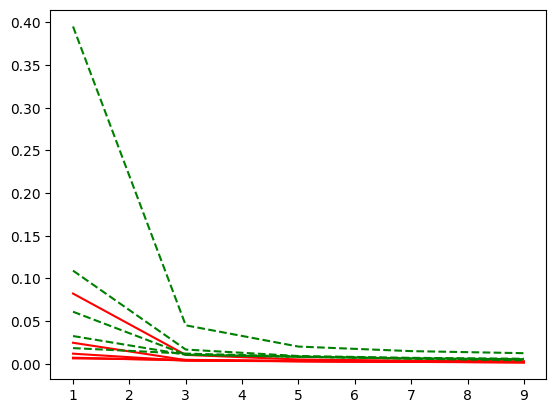

In [ ]:
X = X_fits
norm = np.linalg.norm(X-eo.repeat(pos, "s d -> sens diam height s d", sens=X.shape[0], diam=X.shape[1], height=X.shape[2]), axis=-1)

X_recal = X - eo.repeat(obs, "sens d -> sens diam height s d", s=X.shape[3], diam=X.shape[1], height=X.shape[2])
norm = np.linalg.norm(X_recal-eo.repeat(pos, "s d -> sens diam height s d", sens=X.shape[0], diam=X.shape[1], height=X.shape[2]), axis=-1)


sen = 1+1*3
print(obs[sen])
d0=0
h0=0
plt.ticklabel_format(useOffset = False)
plt.plot(diam, norm.mean(axis=(-1))[sen, :, :], 'r-')
plt.plot(diam, norm.max(axis=-1)[sen, :, :], 'g--')
plt.show()


#check where max error occurs #do with magnets that we have

In [ ]:
#X[0, :, 5, 0], X[1, :, 5, 0], eo.repeat(sensor.pixel, "sens d -> sens diam height s d", s=X.shape[3], diam=X.shape[1], height=X.shape[2])[1, :, 0, 0]


In [ ]:

X_recal.shape

(9, 5, 5, 27000, 3)

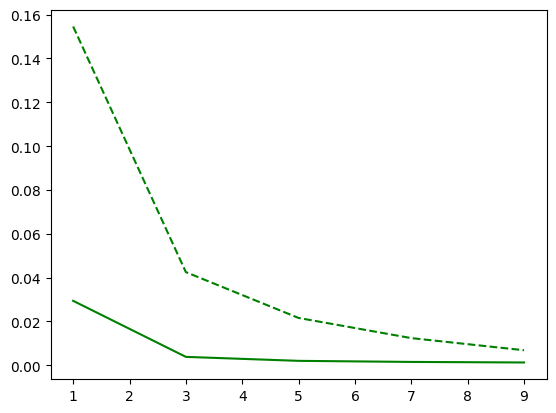

In [ ]:
norm_avg_sens = np.linalg.norm((X_recal-eo.repeat(pos, "s d -> sens diam height s d", sens=X.shape[0], diam=X.shape[1], height=X.shape[2])).mean(axis=0), axis=-1)
norm_avg_sens = np.linalg.norm((X_recal-eo.repeat(pos, "s d -> sens diam height s d", sens=X.shape[0], diam=X.shape[1], height=X.shape[2])).mean(axis=0), axis=-1)


#plt.ticklabel_format(useOffset = True)
plt.plot(diam, norm_avg_sens.mean(axis=(-1))[:, 0], 'g-')
plt.plot(height, norm_avg_sens.max(axis=-1)[0, :], 'g--')
plt.show()


In [ ]:
norm_avg_sens.shape

(5, 5, 27000)

In [ ]:
X

array([[[[[ 2.31991884e-02,  1.95891106e-02,  6.01360331e+00],
          [ 1.76189338e-02, -3.45266555e-02,  6.08036098e+00],
          [-5.73622342e-02,  1.44458789e-02,  6.13878848e+00],
          ...,
          [ 2.05076336e+00,  2.03358779e+00,  7.80000000e+00],
          [ 2.08892714e+00,  1.88594378e+00,  7.94847963e+00],
          [ 1.96465013e+00,  2.04605520e+00,  7.95400056e+00]],

         [[ 8.32417974e-03,  2.87877010e-03,  6.00048352e+00],
          [ 4.21690727e-03, -2.35993197e-03,  6.06644949e+00],
          [-3.59830088e-03, -1.02063007e-02,  6.13837714e+00],
          ...,
          [ 2.03102317e+00,  1.97609920e+00,  7.88927342e+00],
          [ 1.96623338e+00,  1.97594944e+00,  7.94693303e+00],
          [ 1.97237930e+00,  1.98437163e+00,  7.98628849e+00]],

         [[ 2.84799030e-03,  6.03293626e-03,  6.00015695e+00],
          [ 1.95363302e-04,  8.35001571e-03,  6.07367072e+00],
          [-2.15276054e-03,  3.78578705e-03,  6.13983786e+00],
          ...,
      

5mm diam
2mm height 
distance 5mm to 20mm

In [ ]:
magpy.getB(sources="Cylinder",
           observers = [0, 0, 0],
           position = [0, 0, 6],
           dimension = [5, 2],
           magnetization = [0, 0, M])

array([ 0.        ,  0.        , 35.01289324])

: 

: 

: 